# 05 Time Series Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests, adfuller

from typing import List

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# widen the column width and overall display width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

In [4]:
# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [5]:
df: pd.DataFrame = pd.read_csv("../data/interim/data_cleaned.csv")

In [6]:
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

In [7]:
df = df.asfreq('h')

In [8]:
def group_by_column(df: pd.DataFrame, col: str, group_col: str) -> pd.DataFrame:
    """Group data by a specified column and compute mean of target column."""
    return df.groupby(group_col)[col].mean().reset_index()

In [9]:
def plot_time_series(df: pd.DataFrame, col: str, freq: str, title: str, ylabel: str, color: str) -> None:
    """Plot resampled time series."""
    df[col].resample(freq).mean().plot(color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Time")
    plt.grid(True)
    plt.show()

In [10]:
def plot_grouped_bar(df: pd.DataFrame, x: str, y: str, title: str, ylabel: str, color: str, order: list = None) -> None:
    """Plot a bar chart for grouped data."""
    sns.barplot(data=df, x=x, y=y, color=color, order=order)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(x.capitalize())
    plt.xticks(rotation=20)
    plt.grid(True)
    plt.show()

In [11]:
def plot_multiple_grouped_lines(df: pd.DataFrame, cols: list, group_col: str, title_prefix: str, color_palette: list) -> None:
    """Plot grouped line plots for multiple columns with sorted x-axis for categorical groups."""
    
    # Define explicit order for categorical axes
    if group_col == 'weekday':
        category_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    elif group_col == 'timing':
        category_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    else:
        category_order = sorted(df[group_col].dropna().unique()) 

    for i, col in enumerate(cols):
        grouped = group_by_column(df, col, group_col)

        # Reorder the group_col if it's categorical
        grouped[group_col] = pd.Categorical(grouped[group_col], categories=category_order, ordered=True)
        grouped = grouped.sort_values(group_col)

        sns.lineplot(data=grouped, x=group_col, y=col,
                     color=color_palette[i % len(color_palette)], label=col)

    plt.title(f"{title_prefix} by {group_col.capitalize()}")
    plt.ylabel("Mean Energy Consumption")
    plt.xlabel(group_col.capitalize())
    plt.legend(loc='upper right', ncol=2)
    plt.xticks(rotation=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [12]:
# Columns to analyze
appliance_cols = ['dishwasher', 'homeoffice', 'fridge', 'winecellar', 'garagedoor',
                  'barn', 'well', 'microwave', 'livingroom', 'furnace', 'kitchen']

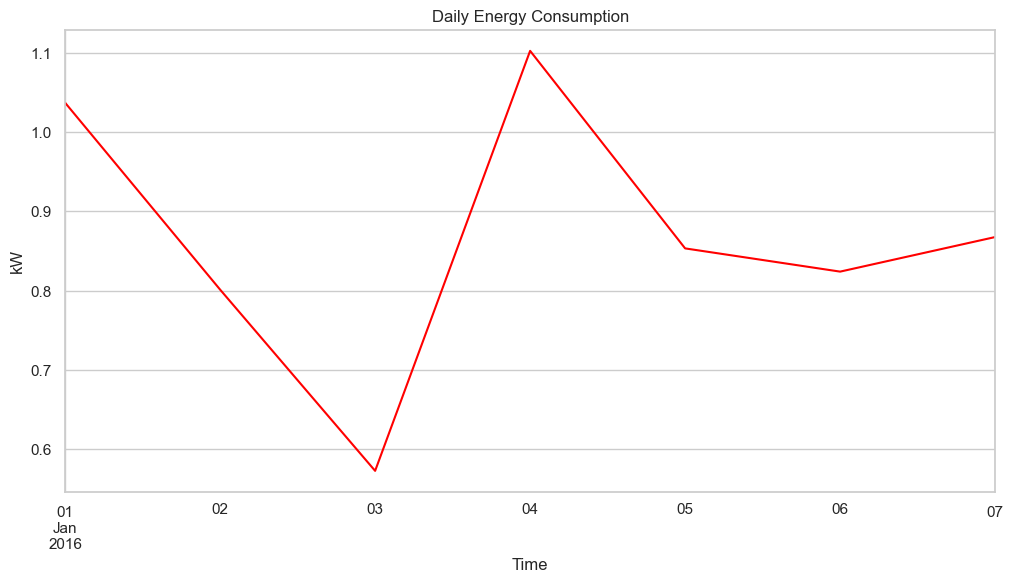

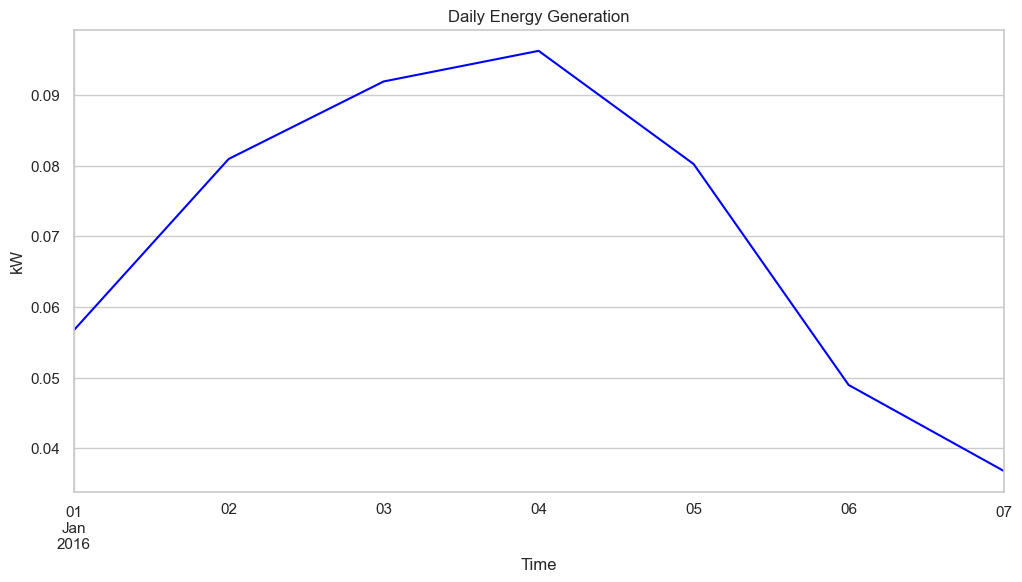

In [13]:
# Time series plots
plot_time_series(df, 'use_house_overall', 'D', "Daily Energy Consumption", "kW", "red")
plot_time_series(df, 'generated_solar', 'D', "Daily Energy Generation", "kW", "blue")

In [14]:
# Grouped bar plots
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
timing_order = ['Morning', 'Afternoon', 'Evening', 'Night']

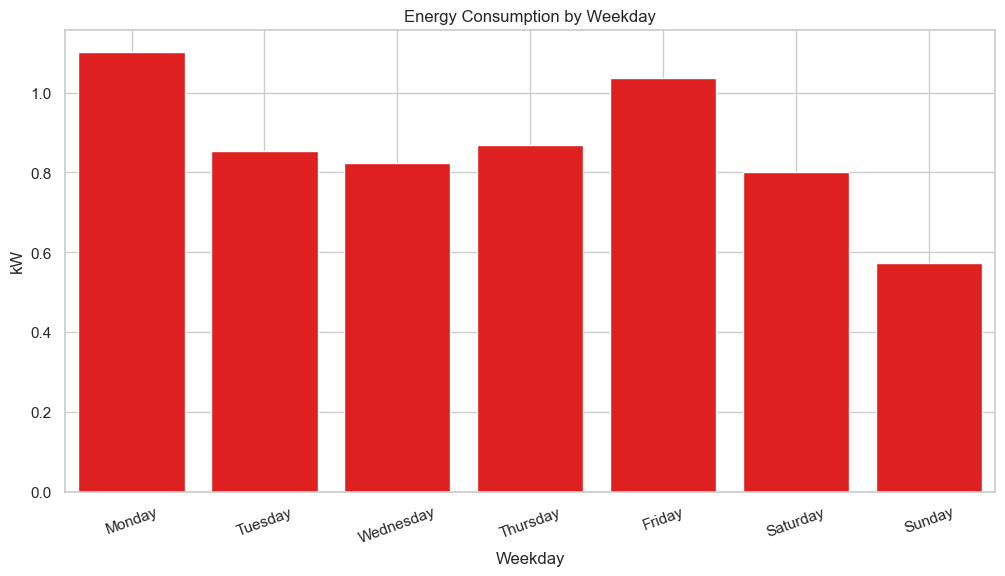

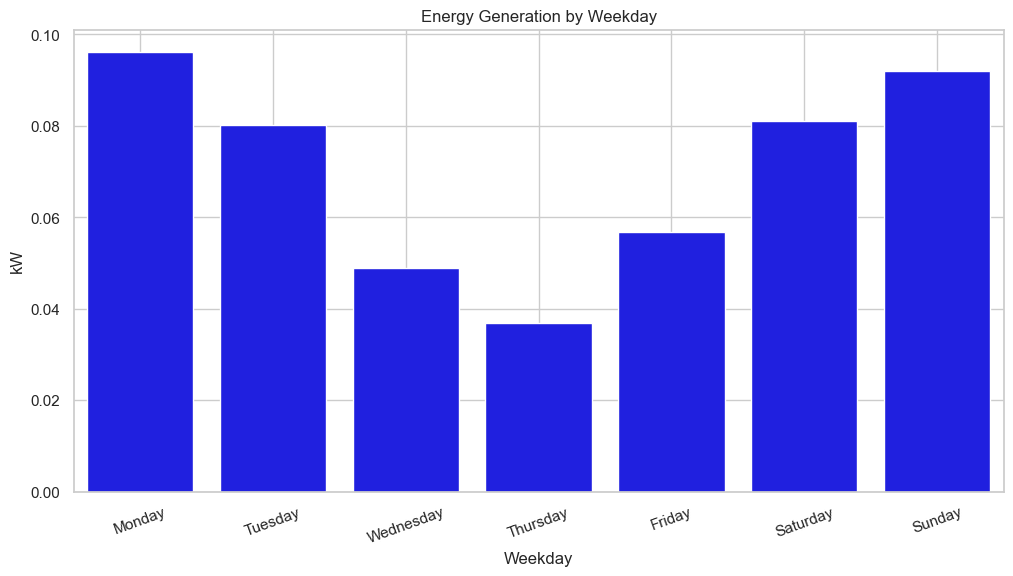

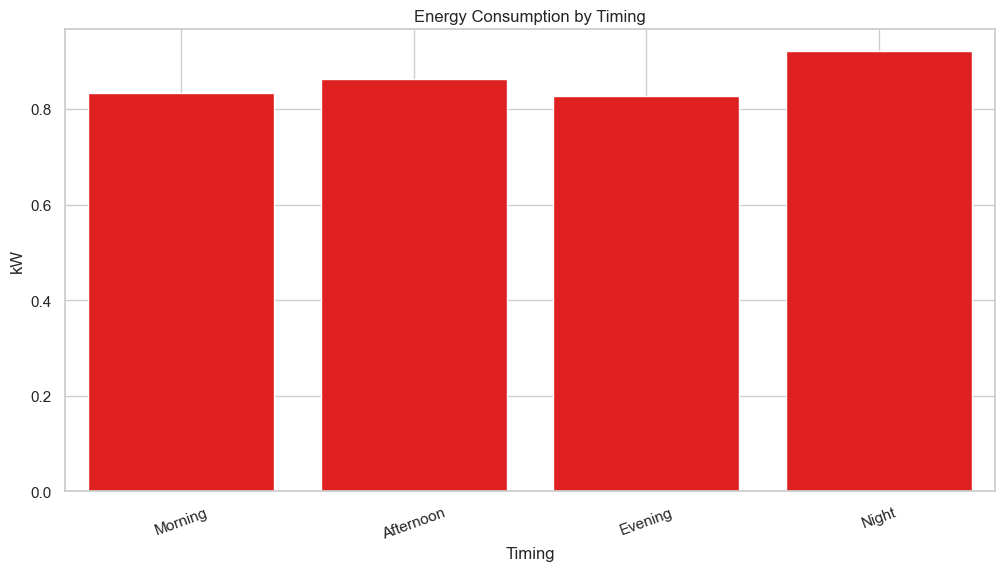

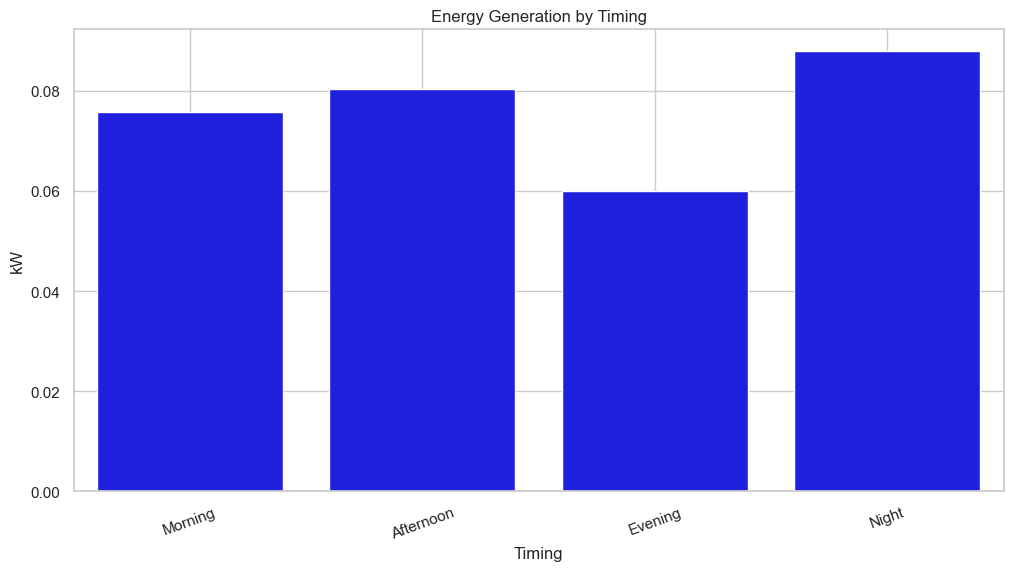

In [15]:
plot_grouped_bar(group_by_column(df, 'use_house_overall', 'weekday'), 'weekday', 'use_house_overall',
                 "Energy Consumption by Weekday", "kW", "red", order=weekday_order)
plot_grouped_bar(group_by_column(df, 'generated_solar', 'weekday'), 'weekday', 'generated_solar',
                 "Energy Generation by Weekday", "kW", "blue", order=weekday_order)
plot_grouped_bar(group_by_column(df, 'use_house_overall', 'timing'), 'timing', 'use_house_overall',
                 "Energy Consumption by Timing", "kW", "red", order=timing_order)
plot_grouped_bar(group_by_column(df, 'generated_solar', 'timing'), 'timing', 'generated_solar',
                 "Energy Generation by Timing", "kW", "blue", order=timing_order)

In [16]:
# Line plots for appliance trends
color_palette = sns.color_palette("tab10", len(appliance_cols))

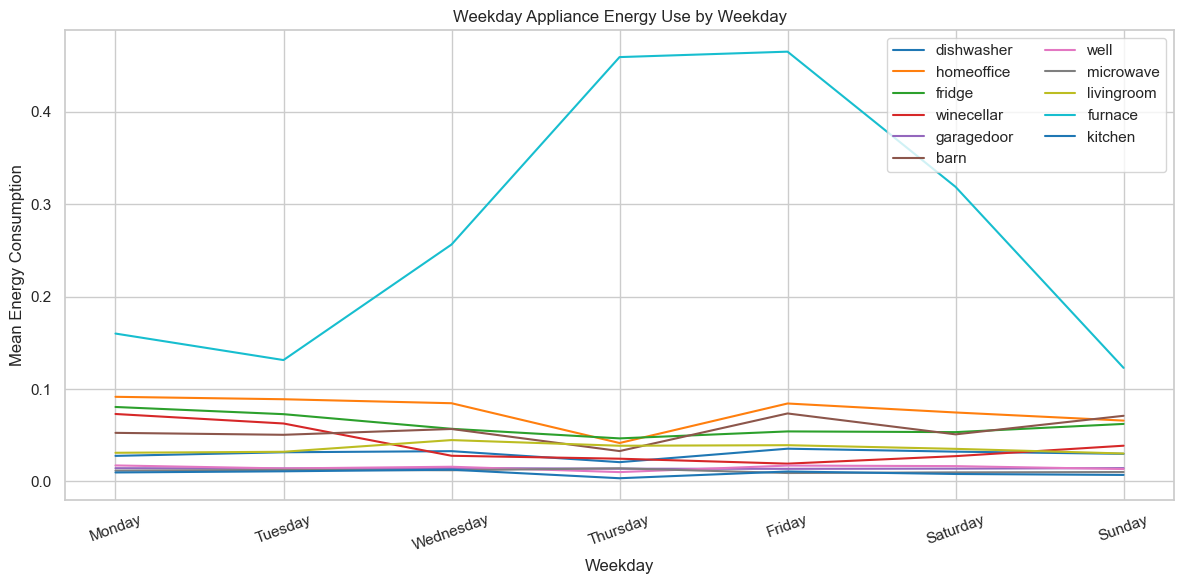

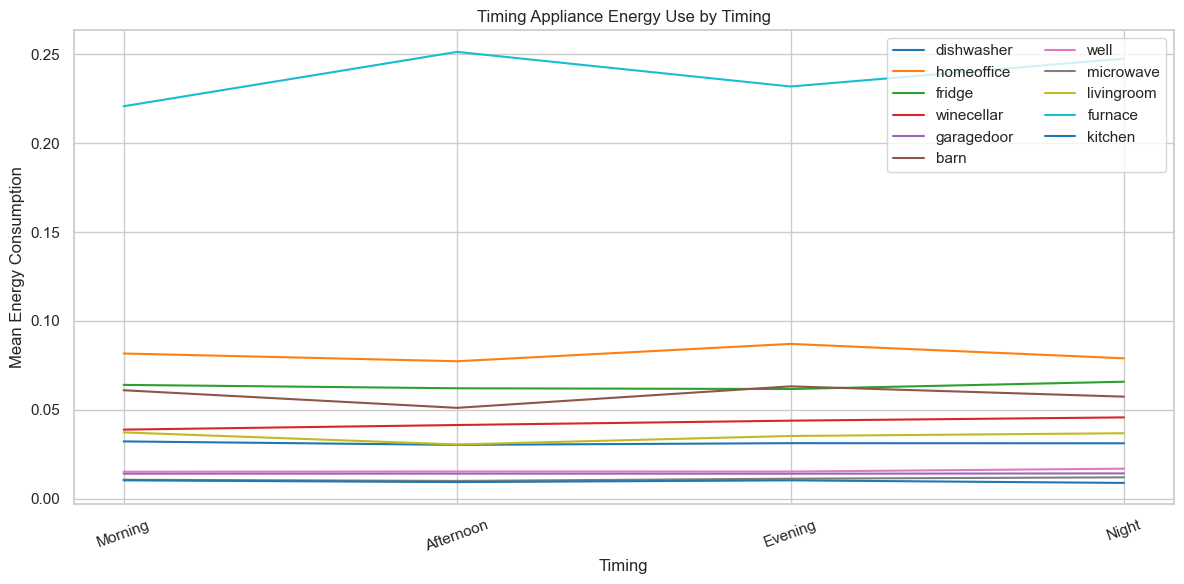

In [17]:
plot_multiple_grouped_lines(df, appliance_cols, 'weekday', "Weekday Appliance Energy Use", color_palette)
plot_multiple_grouped_lines(df, appliance_cols, 'timing', "Timing Appliance Energy Use", color_palette)

In [18]:
def is_stationary(series: pd.Series, alpha: float = 0.05) -> bool:
    """Check if a time series is stationary using ADF test."""
    p_value = adfuller(series.dropna())[1]
    return p_value < alpha

def make_stationary(series: pd.Series) -> pd.Series:
    """Make a series stationary via differencing."""
    return series.diff().dropna()

def granger_causality_matrix(df: pd.DataFrame, 
                             targets: List[str], 
                             predictors: List[str], 
                             maxlag: int = 12, 
                             alpha: float = 0.05) -> pd.DataFrame:
    """
    Run Granger causality tests between each predictor and each target.

    Returns a DataFrame of minimum p-values across lags.
    """
    results = pd.DataFrame(index=targets, columns=predictors, dtype=float)

    for target in targets:
        for predictor in predictors:
            data = df[[target, predictor]].dropna()

            # Skip if either is empty or not enough data
            if data.shape[0] < maxlag + 2:
                results.loc[target, predictor] = np.nan
                continue

            # Make stationary if needed
            for col in [target, predictor]:
                if not is_stationary(data[col]):
                    data[col] = make_stationary(data[col])

            try:
                test = grangercausalitytests(data[[target, predictor]], maxlag=maxlag, verbose=False)
                p_values = [test[i + 1][0]['ssr_chi2test'][1] for i in range(maxlag)]
                results.loc[target, predictor] = np.min(p_values)
            except Exception:
                results.loc[target, predictor] = np.nan

    return results

def plot_granger_heatmap(p_matrix: pd.DataFrame, alpha: float = 0.05) -> None:
    """
    Plot heatmap of Granger causality p-values.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(p_matrix, annot=True, fmt=".3f", cmap="coolwarm", 
                cbar_kws={'label': 'Min p-value'}, 
                vmin=0, vmax=1, linewidths=0.5, linecolor='gray')
    plt.title("Granger Causality Heatmap (min p-value across lags)", fontsize=16)
    plt.xlabel("Predictor (e.g., Weather Variables)")
    plt.ylabel("Target (Appliance Load)")
    plt.axhline(y=0, color='black', linewidth=1)
    plt.tight_layout()
    plt.show()

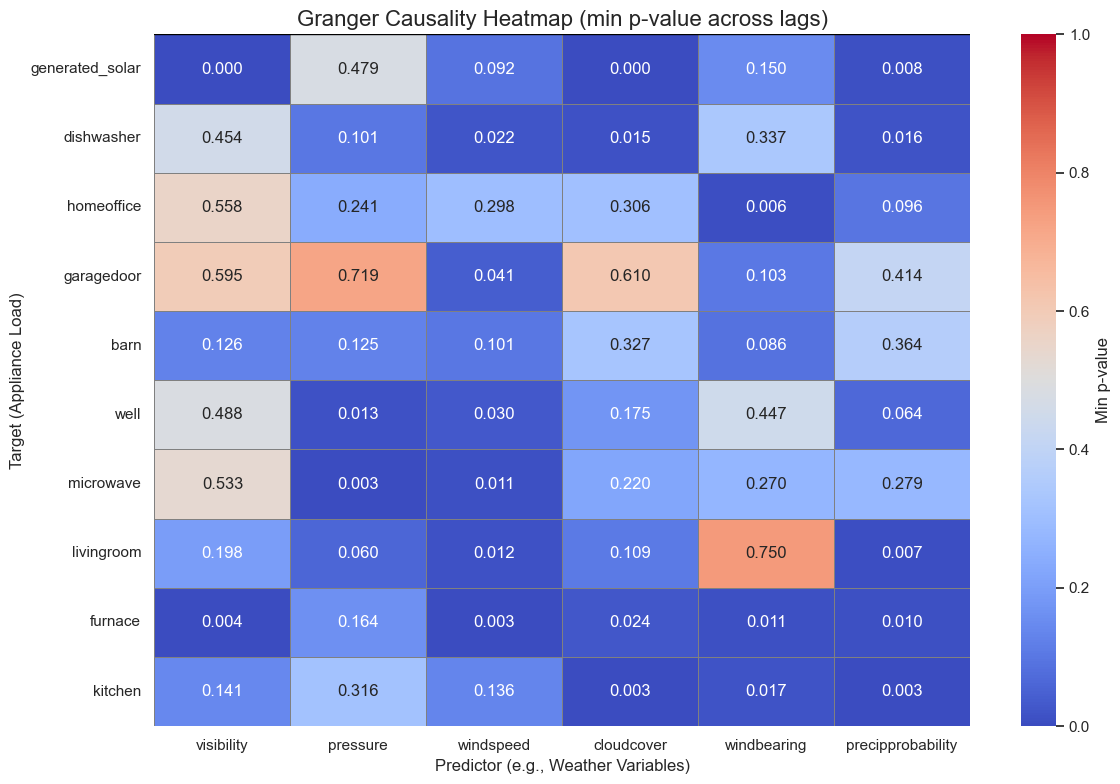

In [19]:
all_columns = [
    'use_house_overall', 'generated_solar', 'dishwasher', 'homeoffice', 'fridge',
    'winecellar', 'garagedoor', 'barn', 'well', 'microwave', 'livingroom',
    'temperature', 'humidity', 'visibility', 'pressure', 'windspeed', 'cloudcover',
    'windbearing', 'precipprobability', 'furnace', 'kitchen', 'year', 'month',
    'day', 'weekofyear', 'hour', 'minute', 'weekday', 'timing'
]
drop_cols = ['year', 'month', 'day', 'weekofyear', 'hour', 'minute', 'weekday', 'timing']
numerical_cols = [col for col in all_columns if col not in drop_cols]

# Split into logical groups
appliance_and_usage = [
    'generated_solar', 'dishwasher', 'homeoffice', 'garagedoor', 'barn', 'well', 'microwave', 'livingroom', 'furnace', 'kitchen'
]
weather_vars = [
    'visibility', 'pressure', 'windspeed', 'cloudcover', 'windbearing', 'precipprobability'
]

# Filter hourly and drop nans
df_granger = df[weather_vars + appliance_and_usage].dropna().copy()

# Run test
pvals = granger_causality_matrix(df_granger, targets=appliance_and_usage, predictors=weather_vars, maxlag=8)
plot_granger_heatmap(pvals)